1. **Data Processing for Machine Learning:**
   - Detect and deal with noise, missing values, and outliers.
   - Categorically encode and rescale data.
   - Split data into predictors and target variables.
   - Obtain train/validation/test folds.

2. **Feature Engineering:**
   - Derive features based on domain knowledge.
   - Produce polynomial/basis functions and interaction features.

3. **Feature Selection and Dimensionality Reduction:**
   - Perform manual selection guided by domain knowledge and EDA.
   - Run and report on automated selection algorithms for the most useful predictors.

4. **Model Building:**
   - Choose suitable algorithms.
   - Fit and tune models using grid-search.
   - Rank and select models based on evaluation metrics and under/overfit trade-off.
   - Build an ensemble with the best performing models/configurations.

5. **Model Evaluation and Analysis:**
   - Evaluate selected models with cross-validation.
   - Analyze true vs predicted plots.
   - Gain insights based on feature importance and model output space.



In [4]:
!pip install scikit-learn category-encoders --quiet
!pip install category-encoders --quiet
!pip install shap --quiet
!pip install joblib

In [5]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy.stats import zscore, pearsonr, norm
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import time
import joblib
from sklearn.metrics import make_scorer
from sklearn.inspection import PartialDependenceDisplay



# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
#data = pd.read_csv('/content/adverts.csv')
data = pd.read_csv('/kaggle/input/adverts/adverts.csv')
data.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [7]:
df = data.copy()

In [8]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nData Types and Info:")
df.info()
print("\nSummary Statistics:")
df.describe()

Dataset Shape: (402005, 12)

Data Types and Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB

Summary Statistics:


,public_reference,mileage,year_of_registration,price
count,4.020050e+05,401878.000000,368694.000000,4.020050e+05
mean,2.020071e+14,37743.595656,2015.006206,1.734197e+04
std,1.691662e+10,34831.724018,7.962667,4.643746e+04
min,2.013072e+14,0.000000,999.000000,1.200000e+02
25%,2.020090e+14,10481.000000,2013.000000,7.495000e+03
50%,2.020093e+14,28629.500000,2016.000000,1.260000e+04
75%,2.020102e+14,56875.750000,2018.000000,2.000000e+04
max,2.020110e+14,999999.000000,2020.000000,9.999999e+06


#  Data Processing for Machine Learning

<Axes: >

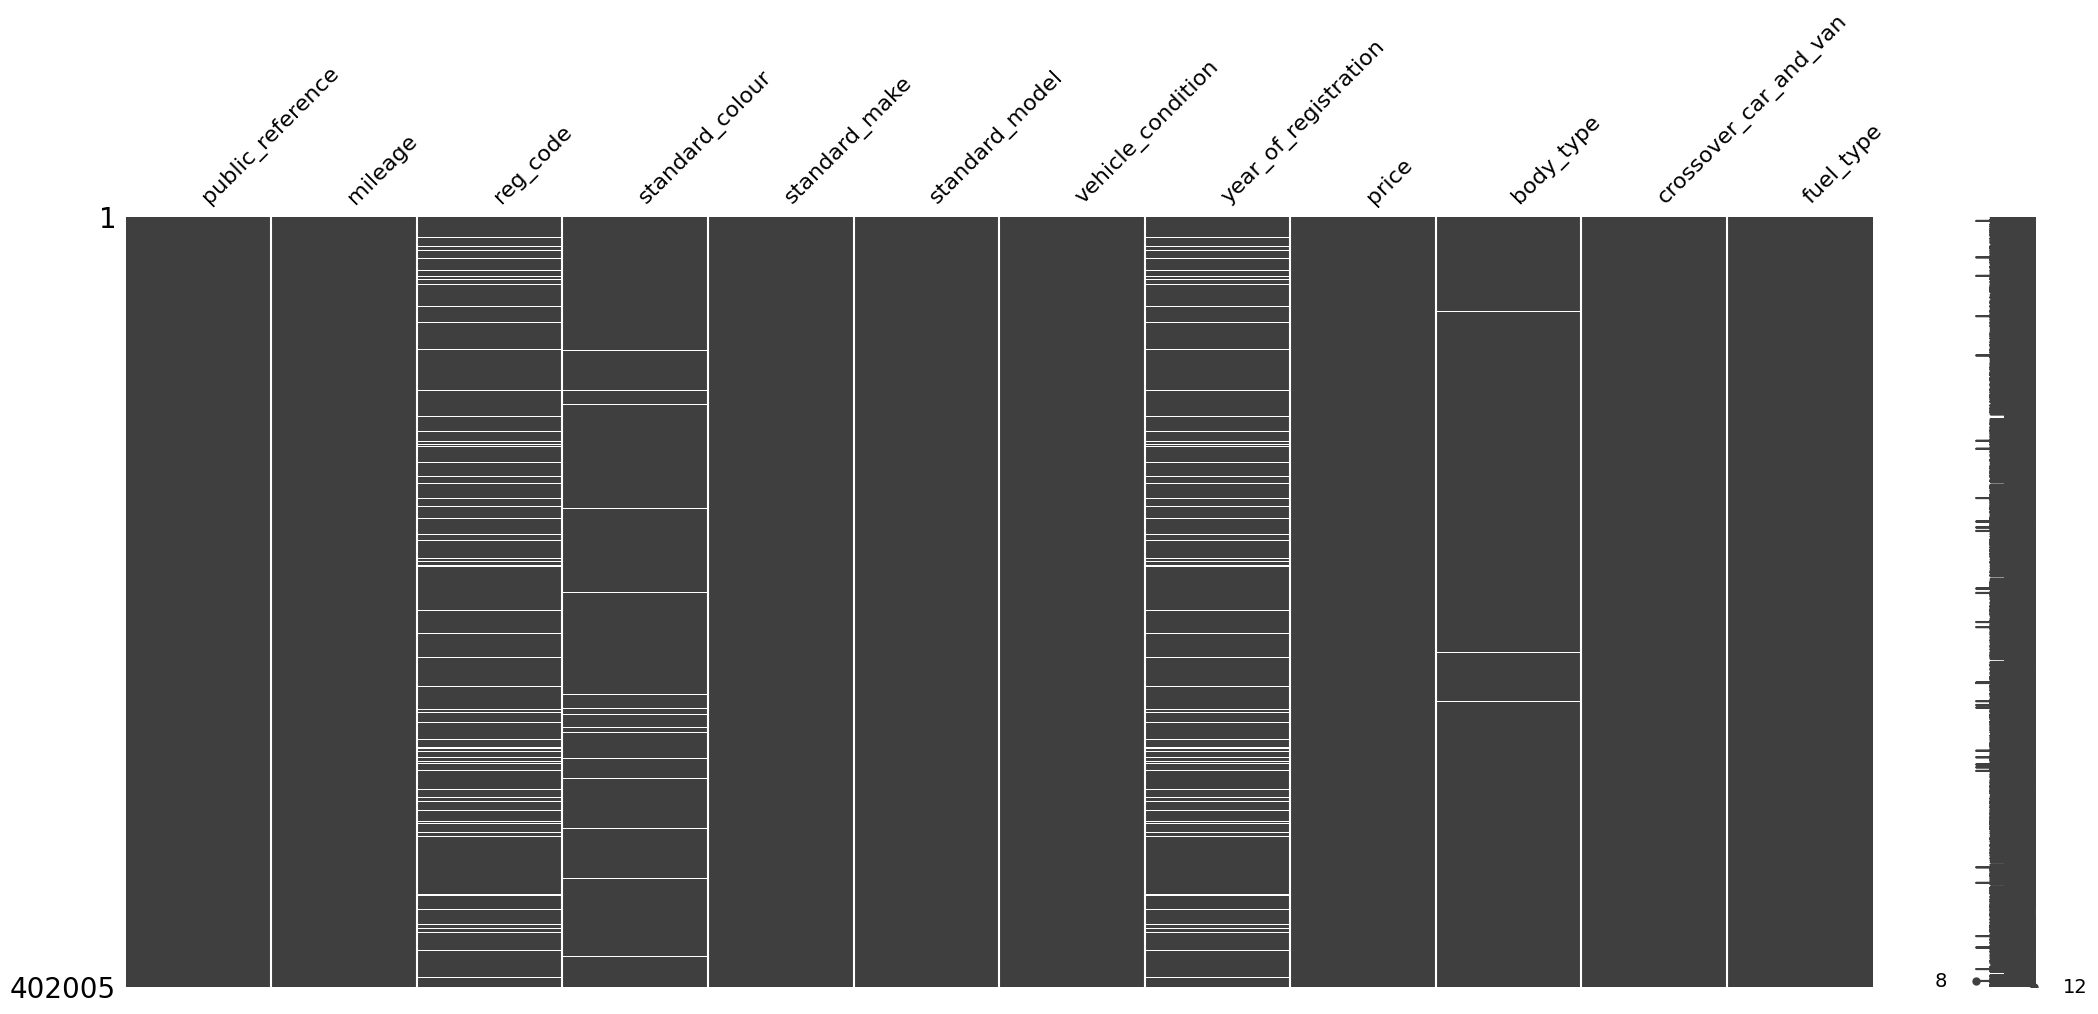

In [9]:

# Visualize missing data patterns
msno.matrix(data)

In [10]:
condition = 'USED'

# Filtering the DataFrame based on the condition and zero mileage
condition_data = data[(
    data['vehicle_condition'] == condition) & (data['mileage'] == 0)]

print(f"'{condition}' vehicles with zero mileage:")
print(condition_data.shape)

# Drop rows that meet the condition from the original DataFrame
data = data.drop(condition_data.index)

'USED' vehicles with zero mileage:
(355, 12)


In [11]:

# Replace NaN values in 'year_of_registration' and 'reg_code'
# with 2021 for cars with a vehicle condition of 'new'
data.loc[data[
    'vehicle_condition'] == 'NEW', 'year_of_registration'] = data.loc[data[
        'vehicle_condition'] == 'NEW', 'year_of_registration'].fillna(2021)
data.loc[data[
    'vehicle_condition'] == 'NEW', 'reg_code'] = data.loc[data[
        'vehicle_condition'] == 'NEW', 'reg_code'].fillna(21)

# Dropping rows with any missing values
df_clean = data.dropna()

df_clean.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,21,Grey,Volvo,XC90,NEW,2021.0,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [12]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

# Separate data based on vehicle_condition
data_new = df_clean[df_clean['vehicle_condition'] == 'NEW'].copy()
data_used = df_clean[df_clean['vehicle_condition'] == 'USED'].copy()

# Apply outlier removal function to both subsets
cleaned_data_new = remove_outliers_iqr(data_new, 'price')
cleaned_data_used = remove_outliers_iqr(data_used, 'price')

# Merge cleaned subsets back into a single DataFrame
cleaned_data = pd.concat([cleaned_data_new, cleaned_data_used])

# Filtering the data outside the given range
filtered_data = cleaned_data[(cleaned_data['year_of_registration'] < 1903) |
 (cleaned_data['year_of_registration'] > 2021)]

# Filter out rows with unusual 'year_of_registration' from filtered_data
unusual_years = filtered_data['year_of_registration'].unique()
cleaned_df = cleaned_data[~cleaned_data[
    'year_of_registration'].isin(unusual_years)]

# Split data into train, validation, and test sets
#X = cleaned_df.drop('price', axis=1)
#y = cleaned_df['price']
#X_train, X_temp, y_train, y_temp = train_test_split(
#    X, y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(
#    X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
#print("Train shape:", X_train.shape, y_train.shape)
#print("Validation shape:", X_val.shape, y_val.shape)
#print("Test shape:", X_test.shape, y_test.shape)

# Feature Engineering

In [13]:
cleaned_df['Age'] = 2021 - cleaned_df['year_of_registration']

# Create mileage per year feature
cleaned_df['mileage_per_year'] = cleaned_df['mileage'] / cleaned_df['year_of_registration']

# Create polynomial features for mileage and vehicle_age
cleaned_df['mileage_squared'] = cleaned_df['mileage']**2
cleaned_df['vehicle_age_squared'] = cleaned_df['Age']**2

# Create interaction feature between standard_model and standard_make
cleaned_df['standard_name'] = cleaned_df[
    'standard_make'] + '_' + cleaned_df['standard_model']

# Create interaction feature between standard_model and standard_make
cleaned_df['standard_description'] = cleaned_df[
    'standard_colour'] + '_' + cleaned_df['body_type']

# Mapping existing fuel types to broader categories
fuel_mapping = {
    'Diesel': 'diesel',
    'Petrol': 'Petrol',
    'Petrol Hybrid': 'Hybrid',
    'Diesel Plug-in Hybrid': 'Hybrid',
    'Electric': 'electric',
    'Diesel Hybrid': 'Hybrid',
    'Petrol Plug-in Hybrid': 'Hybrid',
    'Bi Fuel': 'bi-fuel'
}

# Replace values in 'fuel_type' column using the mapping
cleaned_df['fuel_type'] = cleaned_df['fuel_type'].map(fuel_mapping)

In [14]:
cleaned_df.dtypes

public_reference           int64
mileage                  float64
reg_code                  object
standard_colour           object
standard_make             object
standard_model            object
vehicle_condition         object
year_of_registration     float64
price                      int64
body_type                 object
crossover_car_and_van       bool
fuel_type                 object
Age                      float64
mileage_per_year         float64
mileage_squared          float64
vehicle_age_squared      float64
standard_name             object
standard_description      object
dtype: object

In [15]:
#numeric columns correlation to price
#'price' is the target variable in the DataFrame
numeric_df = cleaned_df.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns
correlation_matrix = numeric_df.corr()

# Select the correlation of predictor variables with the target variable 'price'
price_correlation = correlation_matrix['price']

# Print the correlation of predictor variables with the target variable
print(price_correlation)


public_reference       -0.049999
mileage                -0.540596
year_of_registration    0.591900
price                   1.000000
Age                    -0.591900
mileage_per_year       -0.540660
mileage_squared        -0.336507
vehicle_age_squared    -0.347277
Name: price, dtype: float64


In [16]:
#Drop the reg_code and public_reference columns
cleaned_df.drop(['reg_code', 'public_reference'], axis=1, inplace=True)

In [20]:
cleaned_df.head(2)

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,Age,mileage_per_year,mileage_squared,vehicle_age_squared,standard_name,standard_description
19,0.0,White,Volkswagen,T-Cross,NEW,2021.0,25000,SUV,False,Petrol,0.0,0.0,0.0,0.0,Volkswagen_T-Cross,White_SUV
37,0.0,White,Fiat,Panda,NEW,2021.0,13999,Hatchback,False,Petrol,0.0,0.0,0.0,0.0,Fiat_Panda,White_Hatchback


In [21]:
# Correlation after feature engineering
#'price' is the target variable in the DataFrame
numeric_df = cleaned_df.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns
correlation_matrix = numeric_df.corr()

# Select the correlation of predictor variables with the target variable 'price'
price_correlation = correlation_matrix['price']

# Print the correlation of predictor variables with the target variable
print(price_correlation)


mileage                -0.540596
year_of_registration    0.591900
price                   1.000000
Age                    -0.591900
mileage_per_year       -0.540660
mileage_squared        -0.336507
vehicle_age_squared    -0.347277
Name: price, dtype: float64


In [22]:
#Number of unique values in categorical columns
#Vehicle condition
num_of_veh_condition = cleaned_df['vehicle_condition'].nunique()
print('There are', num_of_veh_condition, 'unique vehilcle conditions')


#Car types
num_of_car_type = cleaned_df['crossover_car_and_van'].nunique()
print('There are', num_of_car_type, 'unique car types')


#Standard_names
num_of_standard_name = cleaned_df['standard_name'].nunique()
print('There are', num_of_standard_name, 'unique standard_name')


#Car Colours
num_of_car_colour = cleaned_df['standard_colour'].nunique()
print('There are', num_of_car_colour, 'unique car colours')


#Vehicle conditions
num_of_car_description = cleaned_df['standard_description'].nunique()
print('There are', num_of_car_description, 'unique car description')


#Car fuel types
num_of_fuel_type = df_clean['fuel_type'].nunique()
print('There are', num_of_fuel_type, 'unique car fuel types')

There are 2 unique vehilcle conditions
There are 2 unique car types
There are 1000 unique standard_name
There are 22 unique car colours
There are 202 unique car description
There are 9 unique car fuel types


In [23]:
cleaned_df.dtypes

mileage                  float64
standard_colour           object
standard_make             object
standard_model            object
vehicle_condition         object
year_of_registration     float64
price                      int64
body_type                 object
crossover_car_and_van       bool
fuel_type                 object
Age                      float64
mileage_per_year         float64
mileage_squared          float64
vehicle_age_squared      float64
standard_name             object
standard_description      object
dtype: object

In [24]:
#Split data into train, validation, and test sets
X = cleaned_df.drop('price', axis=1)
y = cleaned_df['price']
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (259641, 15) (259641,)
Validation shape: (55637, 15) (55637,)
Test shape: (55638, 15) (55638,)


In [25]:
# Target Encoding
categorical_columns = X_train.select_dtypes(
    include='object').columns.tolist()
target_encoder = TargetEncoder(cols=categorical_columns)

# Creating a pipeline for encoding
encoding_pipeline = Pipeline([
    ('target_encoder', target_encoder)
])

# Encoding training data
X_train_encoded = encoding_pipeline.fit_transform(X_train, y_train)

# Transforming validation data
X_val_encoded = encoding_pipeline.transform(X_val)

# Transforming test data
X_test_encoded = encoding_pipeline.transform(X_test)

scoring_function = make_scorer(mean_squared_error)
cv_scores = cross_val_score(encoding_pipeline, X_train, y_train, cv=5, scoring=scoring_function)
#print("Mean MSE from cross-validation:", mse_scores.mean())


# Cross-validation transformation
#cv_scores = cross_val_score(encoding_pipeline, X_train, y_train, cv=5, scoring=mean_squared_error)

# Now you can use X_train_encoded, X_val_encoded, and X_test_encoded in your modeling pipeline

# Feature Selection and Dimensionality Reduction

In [26]:
# Feature Selection
# Use RFE with a Random Forest Regressor to select the top 10 features
rfe = RFE(RandomForestRegressor(), n_features_to_select=10)
X_train_selected = rfe.fit_transform(X_train_encoded, y_train)

# Feature Selection for validation data (using the fitted RFE model)
X_val_selected = rfe.transform(X_val_encoded)

# Dimensionality Reduction
# Use PCA to reduce the number of features to 5
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_selected)

# Dimensionality reduction for validation data (using the fitted PCA model)
X_val_pca = pca.transform(X_val_selected)

# Display the shape of the transformed data
print("Shape after Feature Selection:", X_train_selected.shape)
print("Shape after PCA:", X_train_pca.shape)


Shape after Feature Selection: (259641, 10)
Shape after PCA: (259641, 5)


In [27]:
 X_train_pca[5]

array([ 1.06738455e+10,  2.03808135e+02, -1.73516397e+03,  3.11834917e+03,
        2.22602435e+03])

In [28]:
X_train_selected[5]

array([1.36726782e+04, 1.41516049e+04, 2.00700000e+03, 1.02139845e+04,
       1.22948623e+04, 1.40000000e+01, 5.77977080e+01, 1.34560000e+10,
       1.96000000e+02, 1.41516049e+04])

# Model Building, Model Evaluation and Analysis

### Linear regresssion

In [27]:
start_time = time.time()

# Define the models you want to include in the pipeline
models = {
    'lr': LinearRegression(),
}

# Use PCA to reduce the number of features to 5
#pca = PCA(n_components=5)

# Create a pipeline with PCA and Voting Regressor
pipeline = Pipeline(steps=[
    #('pca', pca),
    ('ensemble', VotingRegressor(estimators=list(models.items())))
])

param_grid = {
    #'pca__n_components': [None, 2, 5, 10],  # Adjust the number of components as needed
    'ensemble__weights': [[1]]  # Only one set of weights for one estimator
}

# Create GridSearchCV with the pipeline as the estimator
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Feature Selection for validation data
X_val_selected = rfe.transform(X_val_encoded)

# Evaluate the best model on the validation set
y_pred = best_model.predict(X_val_selected)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE

print("R^2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

metrics = {"r2": r2, "mae": mae, "rmse": rmse}

end_time = time.time()
execution_time = end_time - start_time

print("Total Execution Time:", execution_time, "seconds")

R^2: 0.7862915965825362
MAE: 3006.150743194664
RMSE: 4317.179490594308
Total Execution Time: 0.8570544719696045 seconds


#### Model Analysis

##### Partial Dependence Plot for the Most important feature

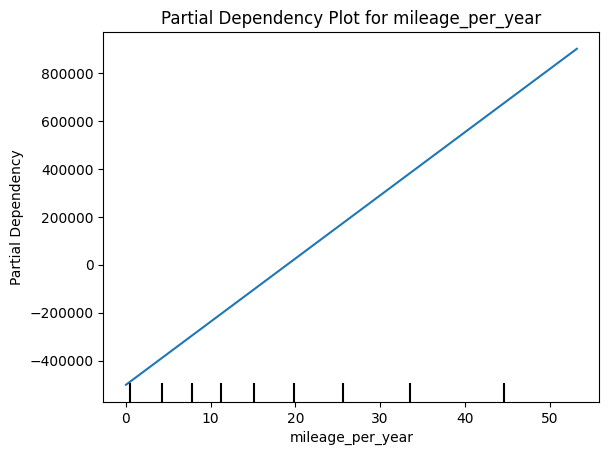

In [28]:
# Extract the underlying linear regression model from the pipeline
linear_regression_model = best_model.named_steps['ensemble'].estimators_[0]

# Get the absolute coefficients' magnitudes
coefficients_magnitude = np.abs(linear_regression_model.coef_)

# Determine the most important feature index
most_important_feature_index = np.argmax(coefficients_magnitude)

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the most important feature
most_important_feature_name = selected_feature_names[most_important_feature_index]

# Create a PartialDependenceDisplay object for the most important feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=linear_regression_model,
    X=X_train_selected,
    features=[most_important_feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the most important feature
pdp_display.plot(ax=plt.gca())
plt.ylabel('Partial Dependency')
plt.xlabel(most_important_feature_name)  # Use the actual feature name here
plt.title(f'Partial Dependency Plot for {most_important_feature_name}')
plt.show()

##### Partial Dependence plot for feature 1

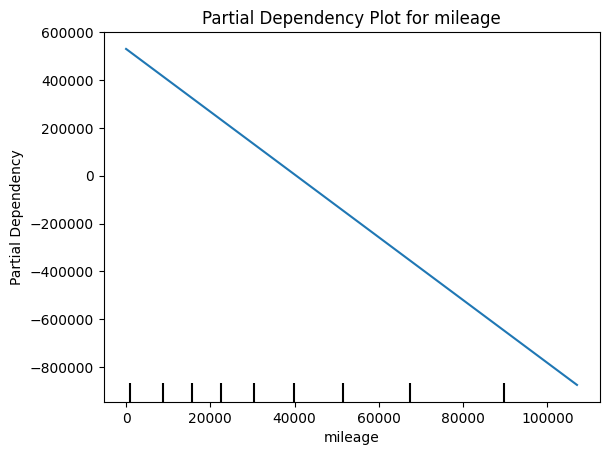

In [29]:
# Extract the underlying linear regression model from the pipeline
linear_regression_model = best_model.named_steps['ensemble'].estimators_[0]

# Choose the feature index for which you want to plot the partial dependence from the model coefficient table
feature_index = 0  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the selected feature
selected_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(linear_regression_model, X_train_selected, features=[feature_index])

# Plot the partial dependence for the chosen feature
pdp_display.plot(ax=plt.gca())
plt.ylabel('Partial Dependency')
plt.xlabel(selected_feature_name)  # Use the actual feature name here
plt.title(f'Partial Dependency Plot for {selected_feature_name}')
plt.show()

##### Partial Dependence Plot for feature 2

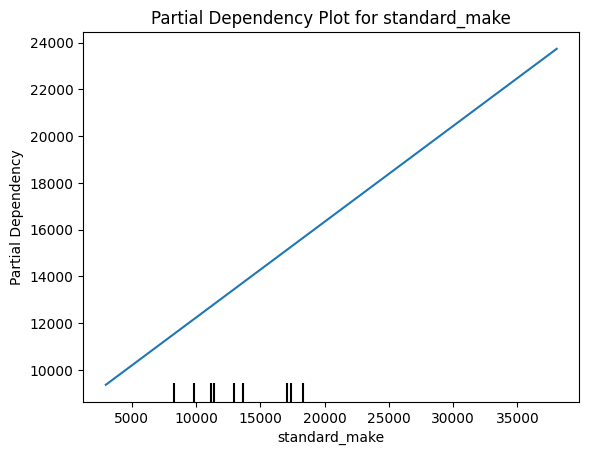

In [39]:
# Choose the feature index for which you want to plot the partial dependence from the model coefficient table
feature_index = 1  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the selected feature
selected_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(linear_regression_model, X_train_selected, features=[feature_index])

# Plot the partial dependence for the chosen feature
pdp_display.plot(ax=plt.gca())
plt.ylabel('Partial Dependency')
plt.xlabel(selected_feature_name)  # Use the actual feature name here
plt.title(f'Partial Dependency Plot for {selected_feature_name}')
plt.show()

##### Partial Dependence Plot for Feature 3

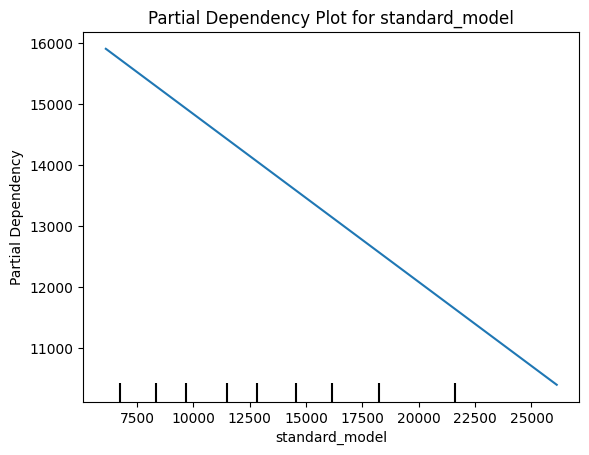

In [31]:
# Choose the feature index for which you want to plot the partial dependence from the model coefficient table
feature_index = 2  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the selected feature
selected_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(linear_regression_model, X_train_selected, features=[feature_index])

# Plot the partial dependence for the chosen feature
pdp_display.plot(ax=plt.gca())
plt.ylabel('Partial Dependency')
plt.xlabel(selected_feature_name)  # Use the actual feature name here
plt.title(f'Partial Dependency Plot for {selected_feature_name}')
plt.show()

###### Partial Dependence Plot for feature 4

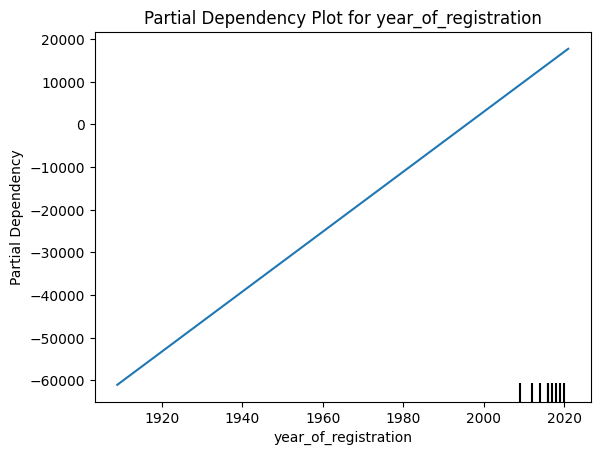

In [32]:
# Choose the feature index for which you want to plot the partial dependence from the model coefficient table
feature_index = 3  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the selected feature
selected_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(linear_regression_model, X_train_selected, features=[feature_index])

# Plot the partial dependence for the chosen feature
pdp_display.plot(ax=plt.gca())
plt.ylabel('Partial Dependency')
plt.xlabel(selected_feature_name)  # Use the actual feature name here
plt.title(f'Partial Dependency Plot for {selected_feature_name}')
plt.show()

**Feature Importance**

In [36]:
# Get the coefficients from the linear regression model
coefficients = linear_regression_model.coef_

# Create a DataFrame to store feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': selected_feature_names, 'Coefficient': coefficients})

# Display the coefficients table
print(coefficients_df)


                Feature   Coefficient
0               mileage    -13.144600
1         standard_make      0.409621
2        standard_model     -0.275636
3  year_of_registration    703.288737
4             body_type      0.106342
5             fuel_type      0.314061
6                   Age   -703.288737
7      mileage_per_year  26337.717336
8   vehicle_age_squared     21.494725
9         standard_name      0.871832


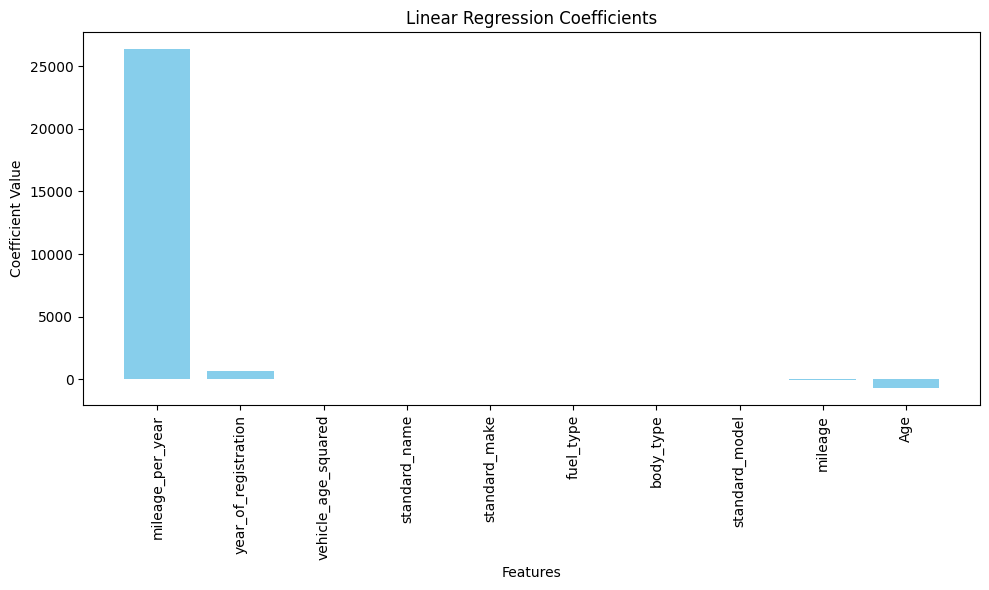

In [38]:
# Sort the coefficients for better visualization
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.tight_layout()
plt.show()

**True vs Predicted Plot**

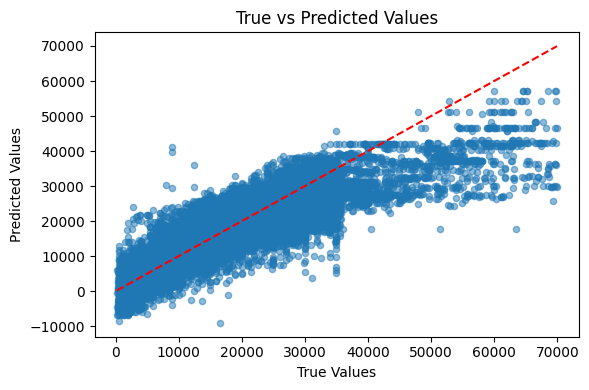

In [33]:
# Plot true vs predicted values
plt.figure(figsize=(6, 4))
plt.scatter(y_val, y_pred, alpha=0.5, s=20)  # Increase marker size
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Add diagonal line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.tight_layout()  # Adjust layout to prevent cutoff of labels
plt.show()

**Global Interpretability**

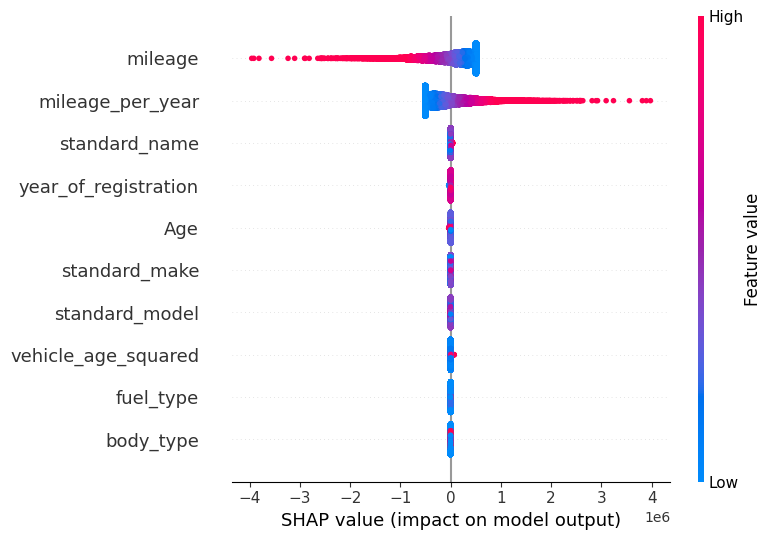

In [34]:
# Extract the linear regression model from the pipeline
linear_regression_model = best_model.named_steps['ensemble'].estimators_[0]

# Compute SHAP values for the linear regression model
explainer = shap.Explainer(linear_regression_model, X_train_selected)
shap_values = explainer.shap_values(X_val_selected)

# Summary plot for global interpretability
shap.summary_plot(shap_values, X_val_selected, feature_names=X_train.columns[rfe.support_])


**Local Interpretability**

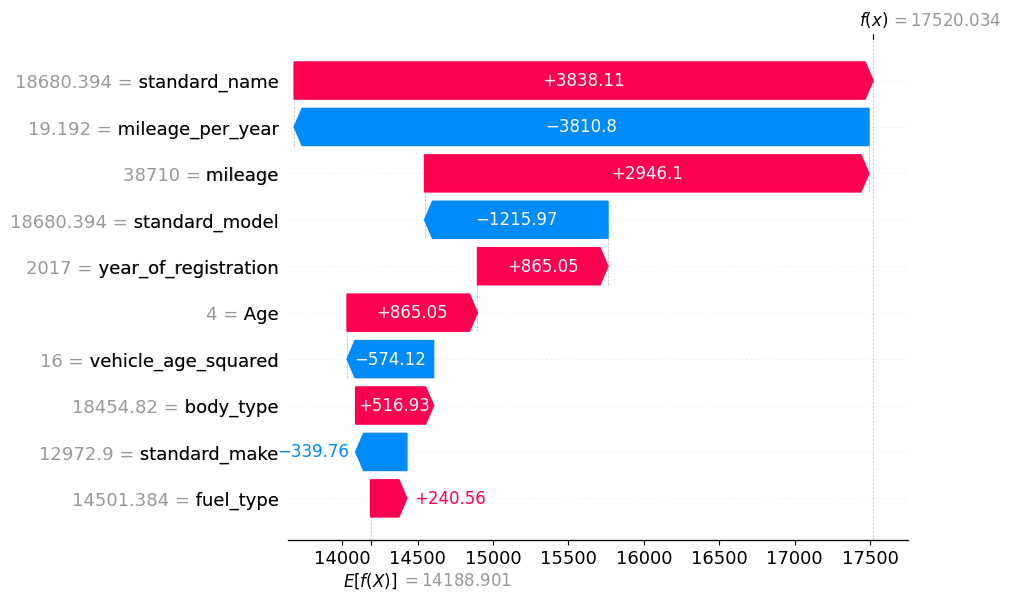

In [40]:
#Interpretability of the 11th instance
instance_index = 10

# Get the feature names
feature_names = X_train.columns[rfe.support_]

# Create an Explanation object for the chosen instance
shap_exp = shap.Explanation(values=shap_values[instance_index],
                             base_values=explainer.expected_value,
                             data=X_val_selected[instance_index],
                             feature_names=feature_names)

# Plot the SHAP values for the chosen instance using waterfall plot
shap.waterfall_plot(shap_exp)
plt.show()

### Random Forest


In [58]:
start_time = time.time()

# Define the models you want to include in the pipeline
models = {
    'rf': RandomForestRegressor(),
    }

# Use PCA to reduce the number of features to 5
#pca = PCA(n_components=5)

# Create a pipeline with PCA and Voting Regressor
pipeline = Pipeline(steps=[
    #('pca', pca),
    ('ensemble', VotingRegressor(estimators=list(models.items())))
])

#param_grid = {
#    'pca__n_components': [None, 2, 5, 10],  # Adjust the number of components as needed
#    'ensemble__weights': [[1, 1, 1], [1, 2, 1], [2, 1, 1]]
#}

param_grid = {
    #'pca__n_components': [None, 2, 5, 10],  # Adjust the number of components as needed
    'ensemble__weights': [[1]]  # Only one set of weights for one estimator
}
# Create GridSearchCV with the pipeline as the estimator
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Feature Selection for validation data
#X_val_selected = rfe.transform(X_val_encoded)

# Evaluate the best model on the validation set
y_pred = best_model.predict(X_val_selected)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE

print("MSE:", mse)
print("R^2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

metrics = {"r2": r2, "mae": mae, "rmse": rmse, "mse": mse}

end_time = time.time()
execution_time = end_time - start_time

print("Total Execution Time:", execution_time, "seconds")


MSE: 5100747.341774243
R^2: 0.9415135581037449
MAE: 1489.1998089132117
RMSE: 2258.483416315967
Total Execution Time: 755.1125531196594 seconds


In [59]:
# Save the best model as a joblib file
joblib.dump(best_model, 'random_forest_car_price_pred.joblib')

['random_forest_car_price_pred.joblib']

X_train_selected as train set without pca in the pipepline

#### Feature Importance

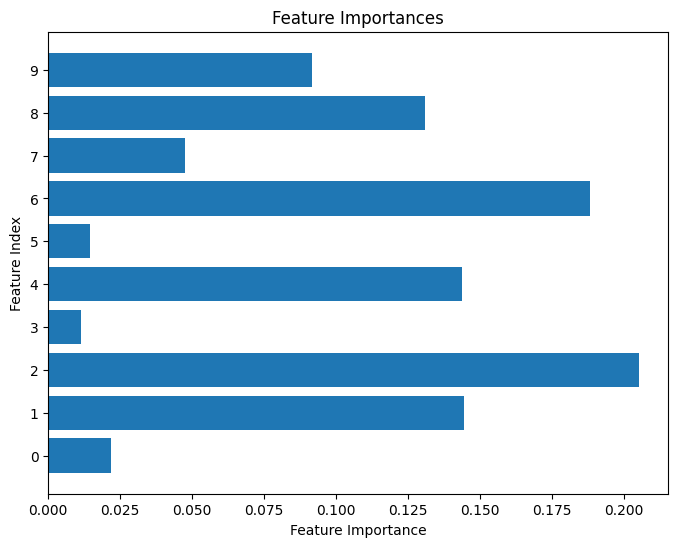

In [ ]:
# Get feature importances from the best model
feature_importances = best_model.named_steps['ensemble'].estimators_[0].feature_importances_

# Assuming X_train_selected is your training data with selected features
# Assuming you have column names
num_features = len(feature_importances)
feature_names = np.arange(num_features)

# Plotting the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(num_features), feature_importances, align='center')
plt.yticks(range(num_features), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Feature Importances')
plt.show()

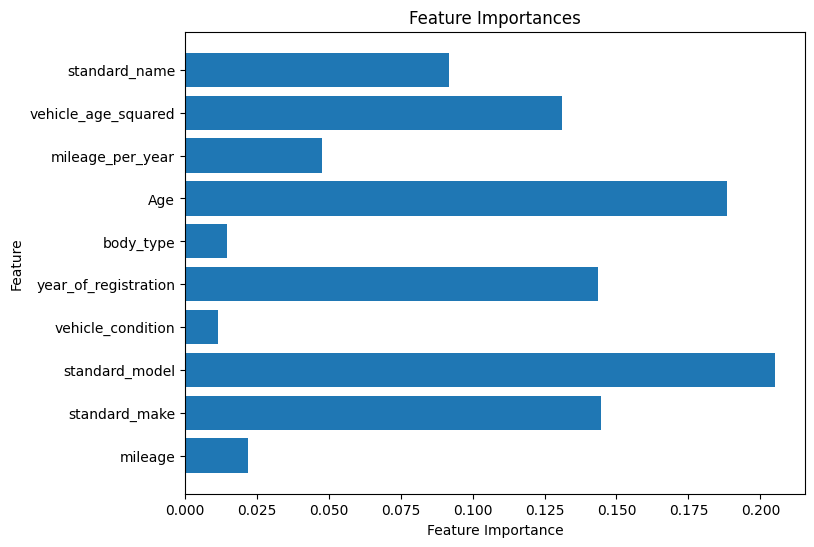

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best model
feature_importances = best_model.named_steps['ensemble'].estimators_[0].feature_importances_

# Assuming X_train_selected is your training data with selected features
feature_names = ['mileage', 'standard_make', 'standard_model', 'vehicle_condition',
                 'year_of_registration', 'body_type', 'Age', 'mileage_per_year',
                 'vehicle_age_squared', 'standard_name']

# Plotting the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


#### True vs Predicted Plot

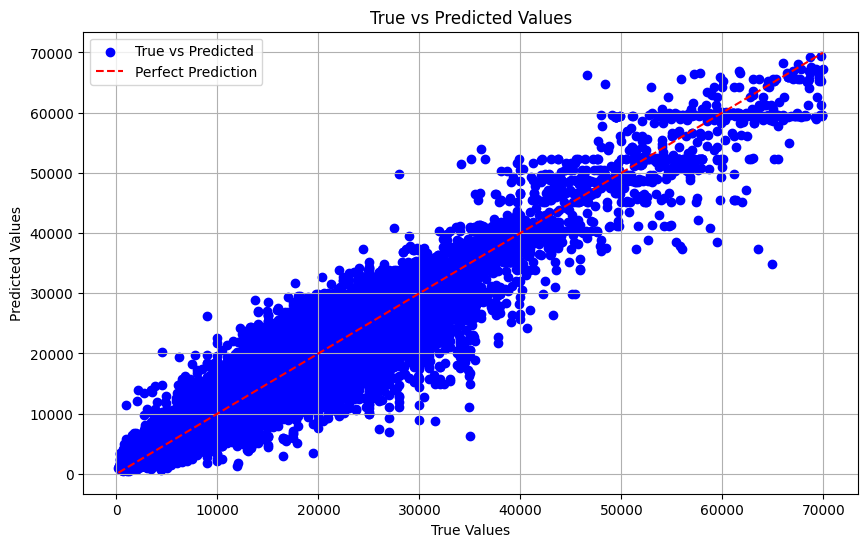

In [27]:
# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, color='blue', label='True vs Predicted')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', label='Perfect Prediction')
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


ExactExplainer explainer: 1001it [29:32,  1.78s/it]


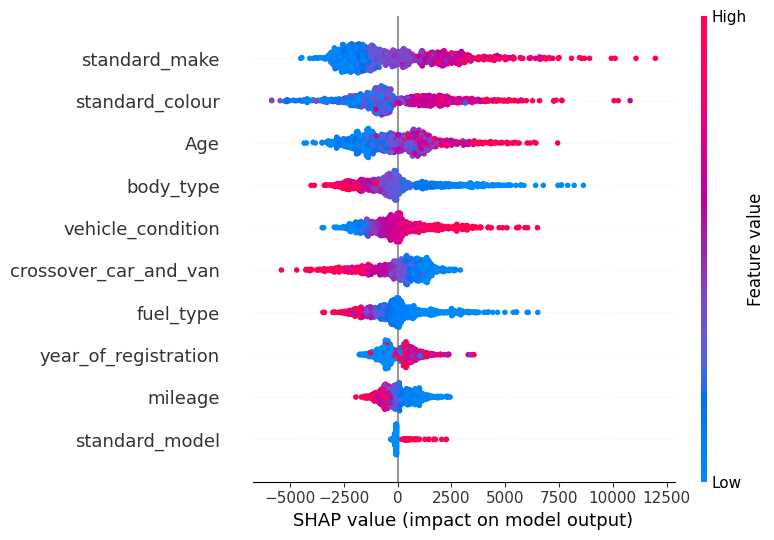

In [ ]:
# Choose a subset of validation data for faster computation
subset_X_val = X_val_selected[:1000]  # Select the first 1000 samples
subset_y_val = y_val[:1000]

# Explain the model's predictions using SHAP
explainer = shap.Explainer(best_model.predict, subset_X_val)
shap_values = explainer(subset_X_val)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, features=subset_X_val, feature_names=X_val.columns)


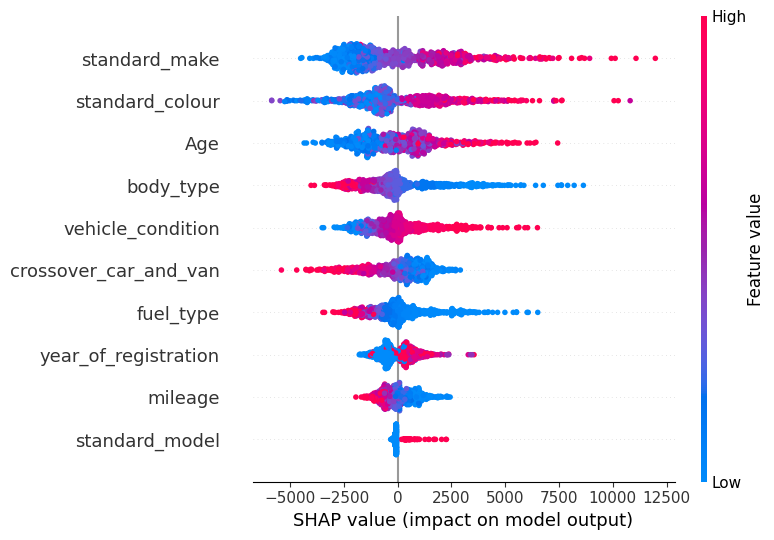

In [ ]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, features=subset_X_val, feature_names=X_val.columns)

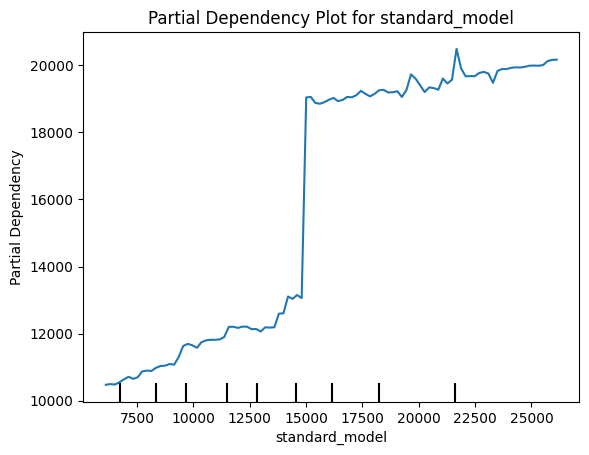

In [28]:
# Extract the underlying model from the pipeline
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Check if the underlying model is RandomForestRegressor or GradientBoostingRegressor
if isinstance(underlying_model, (RandomForestRegressor, GradientBoostingRegressor)):
    # Retrieve feature importances
    importance_scores = underlying_model.feature_importances_
    most_important_feature_index = np.argmax(importance_scores)  # Get the index of the most important feature

    # Get the selected feature names before transformation
    selected_feature_names = X_train.columns[rfe.support_]

    # Get the name of the most important feature
    most_important_feature_name = selected_feature_names[most_important_feature_index]

    # Create a PartialDependenceDisplay object for the most important feature
    pdp_display = PartialDependenceDisplay.from_estimator(underlying_model, X_train_selected, features=[most_important_feature_index])

    # Plot the partial dependence for the most important feature
    pdp_display.plot(ax=plt.gca())
    plt.ylabel('Partial Dependency')
    plt.xlabel(most_important_feature_name)  # Use the actual feature name here
    plt.title(f'Partial Dependency Plot for {most_important_feature_name}')
    plt.show()
else:
    print("Partial dependence plots are not available for the underlying model.")


X_train_selected with Hyper-parameter tuning

In [ ]:
# Start timing
start_time = time.time()

# Define the models you want to include in the pipeline
models = {
    'rf': RandomForestRegressor()
}

# Create a pipeline with Voting Regressor
pipeline = Pipeline(steps=[
    ('ensemble', VotingRegressor(estimators=list(models.items())))
])

# Define hyperparameters for Random Forest
param_grid = {
    'ensemble__rf__n_estimators': [100, 200],        # Number of trees in the forest
    'ensemble__rf__max_depth': [None, 10],              # Maximum depth of the trees
    'ensemble__rf__min_samples_split': [2, 5],          # Minimum number of samples required to split a node
    'ensemble__rf__min_samples_leaf': [1, 2],                # Minimum number of samples required at each leaf node
    'ensemble__rf__max_features': ['auto']      # Number of features to consider when looking for the best split
}

# Create GridSearchCV with the pipeline as the estimator
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
y_pred = best_model.predict(X_val_selected)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE

print("MSE:", mse)
print("R^2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

metrics = {"r2": r2, "mae": mae, "rmse": rmse, "mse": mse}

# End timing
end_time = time.time()
execution_time = end_time - start_time
print("Total Execution Time:", execution_time, "seconds")


The Random Forest Mean Squared Error is: 5436801.39994707
Total Execution Time: 10472.977136135101 seconds


In [ ]:
# Save the best model as a joblib file
joblib.dump(best_model, 'random_forest_X_selecetd.joblib')

['random_forest_X_selecetd.joblib']

#### Feature Importance Analysis

In [ ]:
# Extract the random forest model from the pipeline
rf_model = best_model.named_steps['ensemble'].estimators_[0]

# Initialize a SHAP explainer with the random forest model
explainer = shap.Explainer(rf_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_val_selected)

##### Global Interpretability PLot with SHAP

In [ ]:
#  Plotthe SHAP summary plot

# Show the plot
shap.summary_plot(shap_values, X_val_selected, feature_names=X_train.columns[rfe.support_])

##### Analyzing the feature importance of the Random Forest Model

In [ ]:
# Extract the feature importances from the Gradient Boosting Regressor model
importances = rf_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns[rfe.support_],
    'importance': importances
})

# Round the importances to three decimal places
feature_importances['importance'] = np.round(feature_importances['importance'], 3)

# Print the feature importances
print("Feature Importances:")
print(feature_importances)

Local Interpretability Plot with SHAP

In [ ]:
# generate the SHAP plot for the the 10th instance
instance_index = 10

# Get the feature names
feature_names = X_train.columns[rfe.support_]

# Create an Explanation object for the chosen instance
shap_exp = shap.Explanation(values=shap_values[instance_index],
                             base_values=explainer.expected_value,
                             data=X_val_selected[instance_index],
                             feature_names=feature_names)

# Plot the SHAP values for the chosen instance using waterfall plot
shap.waterfall_plot(shap_exp)

plt.show()

##### Analyzing the feature importance of the Random Forest model

In [ ]:
# Extract the feature importances from the Gradient Boosting Regressor model
importances = rf_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns[rfe.support_],
    'importance': importances
})

# Round the importances to three decimal places
feature_importances['importance'] = np.round(feature_importances['importance'], 3)

# Print the feature importances
print("Feature Importances:")
print(feature_importances)

In [ ]:
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_sorted['feature'], feature_importances_sorted['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

##### True vs Predicted Plot

In [ ]:
# Predict on the validation set
y_pred = best_model.predict(X_val_selected)

# Create a scatter plot of true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.show()

### Gradient Boosting Regressor

In [30]:
start_time = time.time()

# Define the models you want to include in the pipeline
models = {
    'gb': GradientBoostingRegressor()
}

# Use PCA to reduce the number of features to 5
#pca = PCA(n_components=5)

# Create a pipeline with PCA and Voting Regressor
pipeline = Pipeline(steps=[
    #('pca', pca),
    ('ensemble', VotingRegressor(estimators=list(models.items())))
])

#param_grid = {
#    'pca__n_components': [None, 2, 5, 10],  # Adjust the number of components as needed
#    'ensemble__weights': [[1, 1, 1], [1, 2, 1], [2, 1, 1]]
#}

param_grid = {
    #'pca__n_components': [None, 2, 5, 10],  # Adjust the number of components as needed
    'ensemble__weights': [[1]]  # Only one set of weights for one estimator
}
# Create GridSearchCV with the pipeline as the estimator
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Feature Selection for validation data
#X_val_selected = rfe.transform(X_val_encoded)

# Evaluate the best model on the validation set
y_pred = best_model.predict(X_val_selected)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE

print("MSE:", mse)
print("R^2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

metrics = {"r2": r2, "mae": mae, "rmse": rmse, "mse": mse}

end_time = time.time()
execution_time = end_time - start_time

print("Total Execution Time:", execution_time, "seconds")


# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5]
# }

MSE: 9873809.547799801
R^2: 0.8867844357467803
MAE: 2121.0843073288447
RMSE: 3142.261852201341
Total Execution Time: 277.71575903892517 seconds


In [31]:
# Extract the Gradient Boosting Regressor model from the pipeline
gb_model = best_model.named_steps['ensemble'].estimators_[0]

# Initialize a SHAP explainer with the Gradient Boosting Regressor model
explainer = shap.Explainer(gb_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_val_selected)

# Now you can plot the SHAP values as desired

##### Partial dependency Plot for the most important feature

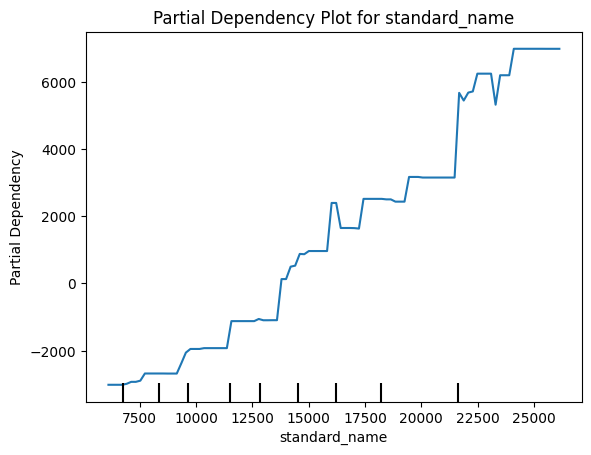

In [32]:
# Extract the underlying model from the pipeline
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Check if the underlying model is RandomForestRegressor or GradientBoostingRegressor
if isinstance(underlying_model, (RandomForestRegressor, GradientBoostingRegressor)):
    # Retrieve feature importances
    importance_scores = underlying_model.feature_importances_
    most_important_feature_index = np.argmax(importance_scores)  # Get the index of the most important feature

    # Get the selected feature names before transformation
    selected_feature_names = X_train.columns[rfe.support_]

    # Get the name of the most important feature
    most_important_feature_name = selected_feature_names[most_important_feature_index]

    # Create a PartialDependenceDisplay object for the most important feature
    pdp_display = PartialDependenceDisplay.from_estimator(underlying_model, X_train_selected, features=[most_important_feature_index])

    # Plot the partial dependence for the most important feature
    pdp_display.plot(ax=plt.gca())
    plt.ylabel('Partial Dependency')
    plt.xlabel(most_important_feature_name)  # Use the actual feature name here
    plt.title(f'Partial Dependency Plot for {most_important_feature_name}')
    plt.show()
else:
    print("Partial dependence plots are not available for the underlying model.")


##### Global Interpretabilty Plot

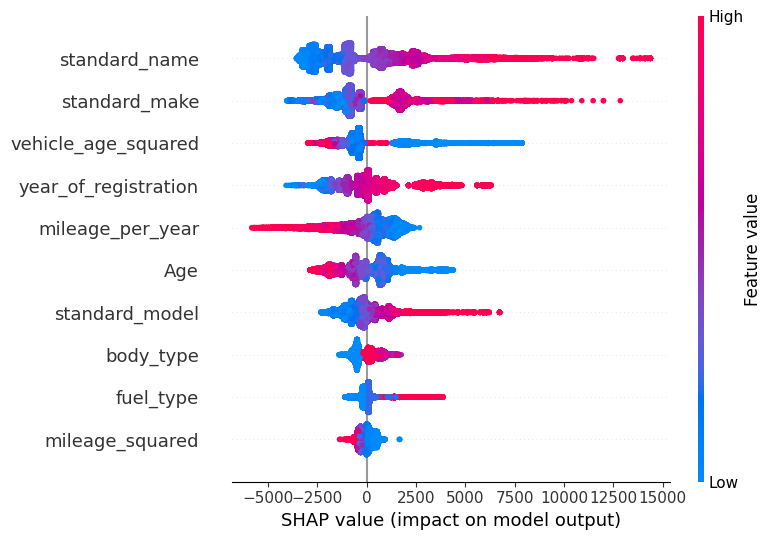

In [33]:
# Plot the SHAP summary plot
#shap.summary_plot(shap_values, X_val_selected, plot_type="bar")

# Show the plot
shap.summary_plot(shap_values, X_val_selected, feature_names=X_train.columns[rfe.support_])

##### Local Interpretability Plot

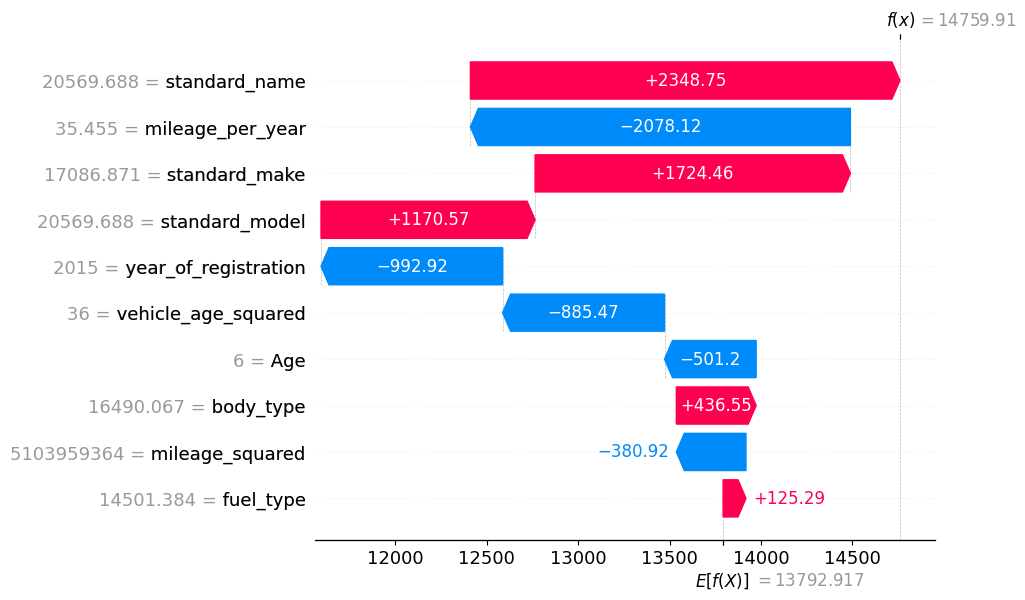

In [34]:
# Choose an instance for which you want to generate the SHAP plot (e.g., the 201 instance)
instance_index = 200

# Get the feature names
feature_names = X_train.columns[rfe.support_]

# Create an Explanation object for the chosen instance
shap_exp = shap.Explanation(values=shap_values[instance_index],
                             base_values=explainer.expected_value,
                             data=X_val_selected[instance_index],
                             feature_names=feature_names)

# Plot the SHAP values for the chosen instance using waterfall plot
shap.waterfall_plot(shap_exp)

##### Analyzing the feature importance of the Gradient Bossting Regressor

In [35]:
# Extract the feature importances from the Gradient Boosting Regressor model
importances = gb_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns[rfe.support_],
    'importance': importances
})

# Round the importances to three decimal places
feature_importances['importance'] = np.round(feature_importances['importance'], 3)

# Print the feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
                feature  importance
0         standard_make       0.109
1        standard_model       0.100
2  year_of_registration       0.136
3             body_type       0.009
4             fuel_type       0.013
5                   Age       0.109
6      mileage_per_year       0.059
7       mileage_squared       0.004
8   vehicle_age_squared       0.212
9         standard_name       0.249


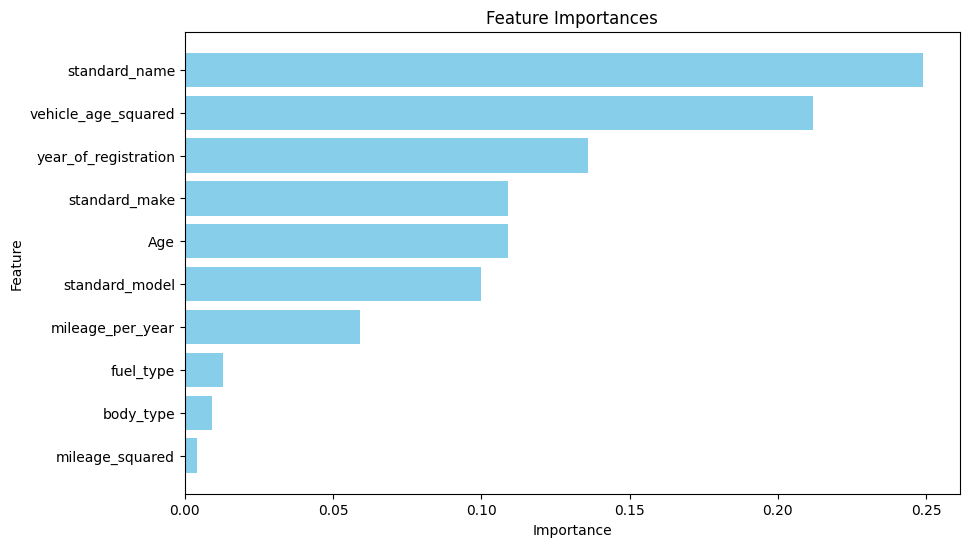

In [36]:
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_sorted['feature'], feature_importances_sorted['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

##### True vs Predicted Plot

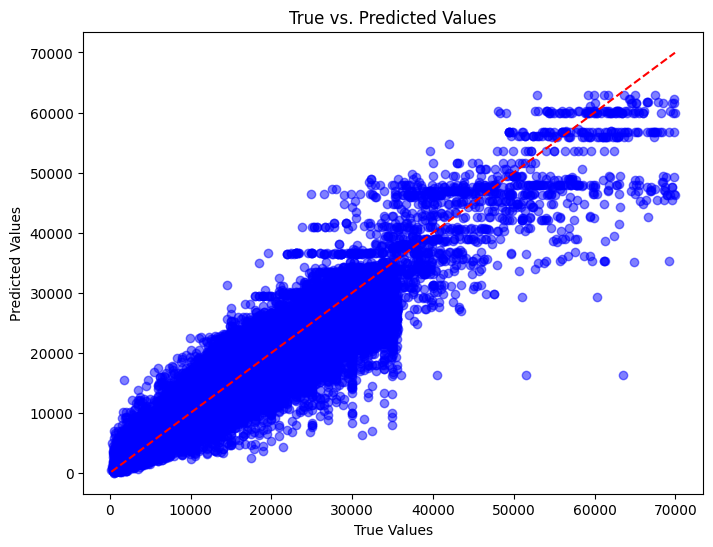

In [37]:
# Predict on the validation set
y_pred = best_model.predict(X_val_selected)

# Create a scatter plot of true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.show()

### VotingRegressor

In [39]:
start_time = time.time()

# Define the models you want to include in the pipeline
models = {
    'lr': LinearRegression(),
    'rf': RandomForestRegressor(),
    'gb': GradientBoostingRegressor()
}

# Use PCA to reduce the number of features to 5
#pca = PCA(n_components=5)

# Create a pipeline with PCA and Voting Regressor
pipeline = Pipeline(steps=[
    #('pca', pca),
    ('ensemble', VotingRegressor(estimators=list(models.items())))
])

param_grid = {
    #'pca__n_components': [None, 2, 5],  # Reduced number of components
    'ensemble__weights': [[1, 1, 1]]  # Only one set of weights
}

# Create GridSearchCV with the pipeline as the estimator
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3  # Reduced number of CV folds
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
y_pred = best_model.predict(X_val_selected)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE

print("MSE:", mse)
print("R^2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

metrics = {"r2": r2, "mae": mae, "rmse": rmse, "mse": mse}

end_time = time.time()
execution_time = end_time - start_time

print("Total Execution Time:", execution_time, "seconds")

MSE: 8024477.788781643
R^2: 0.907989335190612
MAE: 1954.1134894339975
RMSE: 2832.750922474767
Total Execution Time: 598.751259803772 seconds


##### Partial dependency plot for the most important feature

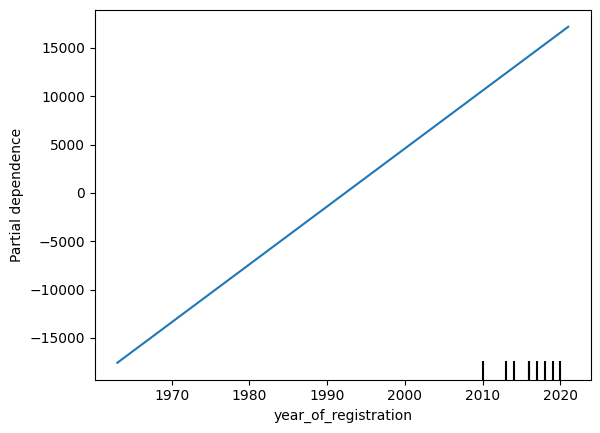

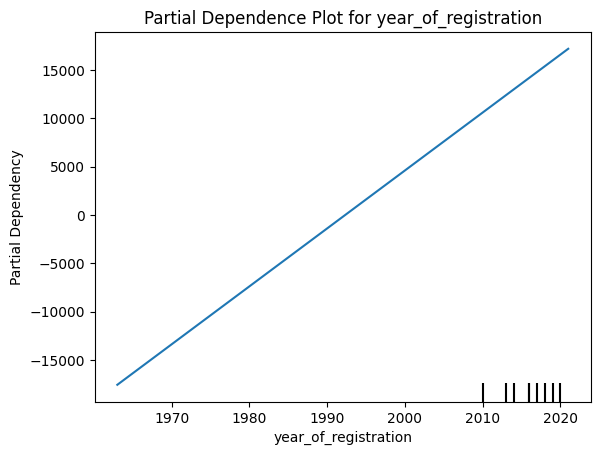

In [40]:
from sklearn.inspection import PartialDependenceDisplay

# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Determine the most important feature index based on the absolute coefficients' magnitudes
most_important_feature_index = np.argmax(np.abs(underlying_model.coef_))

# Get the name of the most important feature
most_important_feature_name = selected_feature_names[most_important_feature_index]

# Create a PartialDependenceDisplay object for the most important feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=underlying_model,
    X=X_val_selected,
    features=[most_important_feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the most important feature
pdp_display.plot()
plt.ylabel('Partial Dependency')
plt.xlabel(most_important_feature_name)
plt.title(f'Partial Dependence Plot for {most_important_feature_name}')
plt.show()

##### Partial Dependency Plot for feature 1

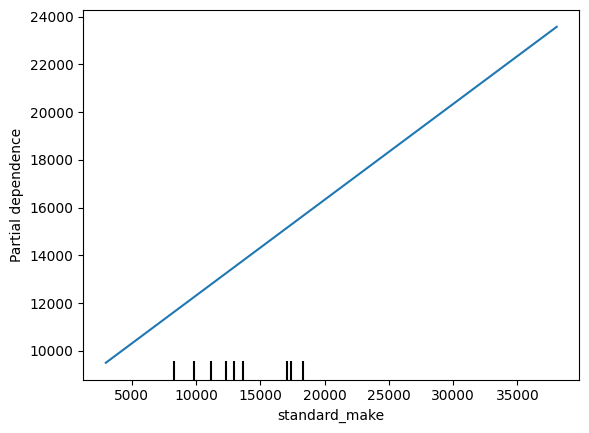

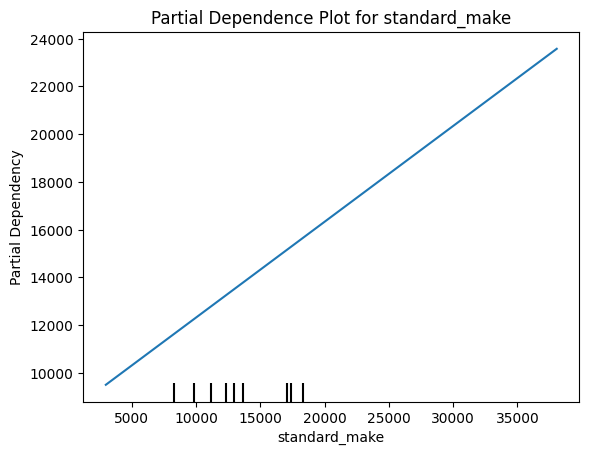

In [41]:
# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Choose the feature index for which you want to plot the partial dependence
feature_index = 0  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the chosen feature
chosen_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=underlying_model,
    X=X_val_selected,
    features=[feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the chosen feature
pdp_display.plot()
plt.ylabel('Partial Dependency')
plt.xlabel(chosen_feature_name)
plt.title(f'Partial Dependence Plot for {chosen_feature_name}')
plt.show()


##### Partial Depandency Plot for feature 2

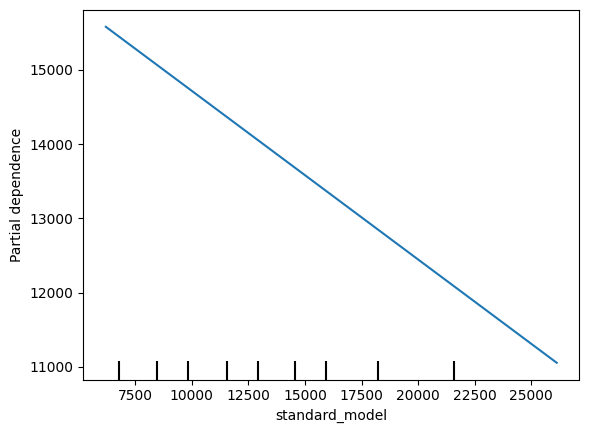

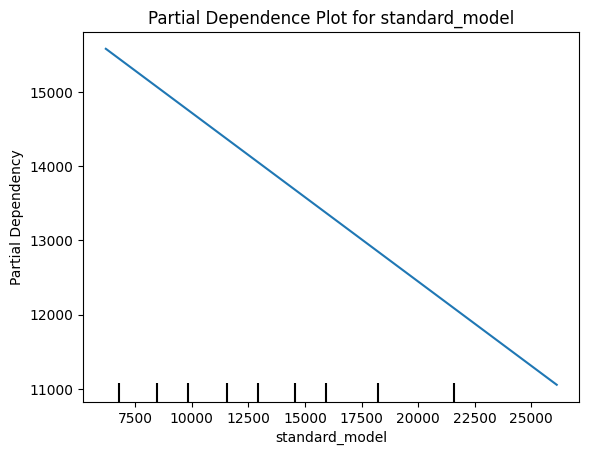

In [42]:
# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Choose the feature index for which you want to plot the partial dependence
feature_index = 1  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the chosen feature
chosen_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=underlying_model,
    X=X_val_selected,
    features=[feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the chosen feature
pdp_display.plot()
plt.ylabel('Partial Dependency')
plt.xlabel(chosen_feature_name)
plt.title(f'Partial Dependence Plot for {chosen_feature_name}')
plt.show()


##### Partial Dependency Plot for Feature 3

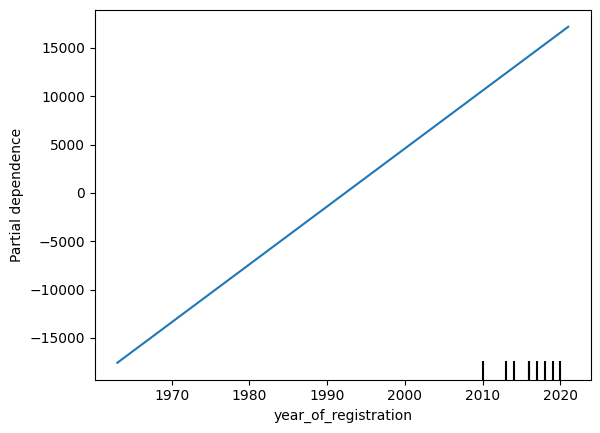

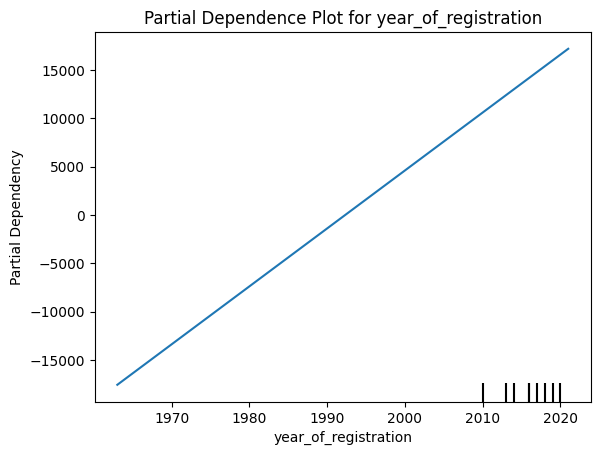

In [43]:
# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Choose the feature index for which you want to plot the partial dependence
feature_index = 2  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the chosen feature
chosen_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=underlying_model,
    X=X_val_selected,
    features=[feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the chosen feature
pdp_display.plot()
plt.ylabel('Partial Dependency')
plt.xlabel(chosen_feature_name)
plt.title(f'Partial Dependence Plot for {chosen_feature_name}')
plt.show()


##### Partial Dependency Plot for feature 4

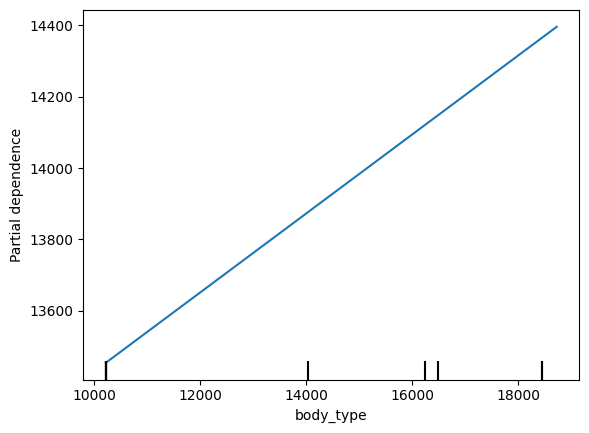

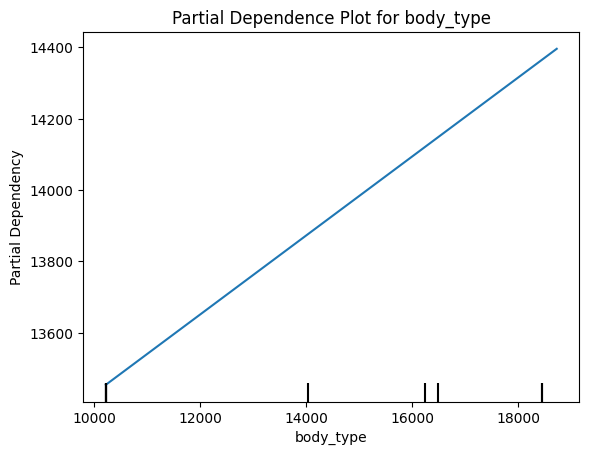

In [44]:
# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Choose the feature index for which you want to plot the partial dependence
feature_index = 3  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the chosen feature
chosen_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=underlying_model,
    X=X_val_selected,
    features=[feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the chosen feature
pdp_display.plot()
plt.ylabel('Partial Dependency')
plt.xlabel(chosen_feature_name)
plt.title(f'Partial Dependence Plot for {chosen_feature_name}')
plt.show()


###### Partial Dependency Plot for feature 5

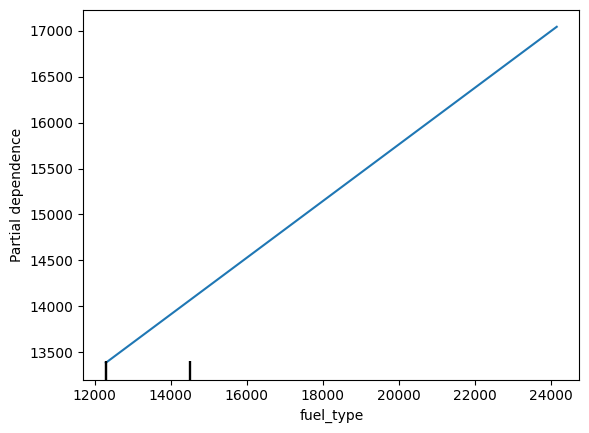

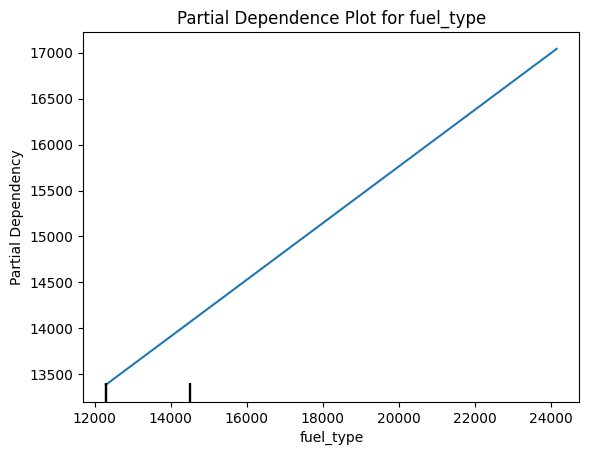

In [45]:
# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Choose the feature index for which you want to plot the partial dependence
feature_index = 4  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the chosen feature
chosen_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=underlying_model,
    X=X_val_selected,
    features=[feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the chosen feature
pdp_display.plot()
plt.ylabel('Partial Dependency')
plt.xlabel(chosen_feature_name)
plt.title(f'Partial Dependence Plot for {chosen_feature_name}')
plt.show()


##### Partial Dependency Plot for fetaure 6

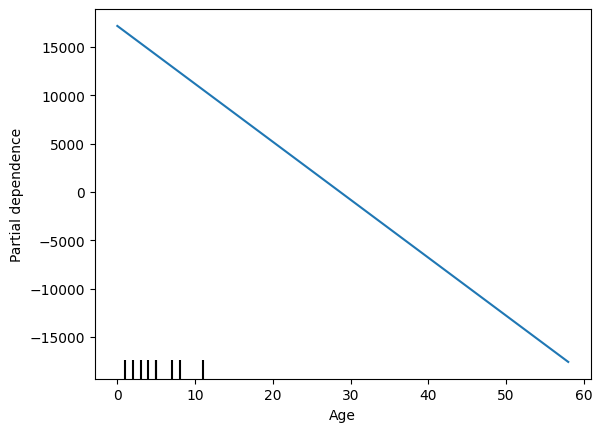

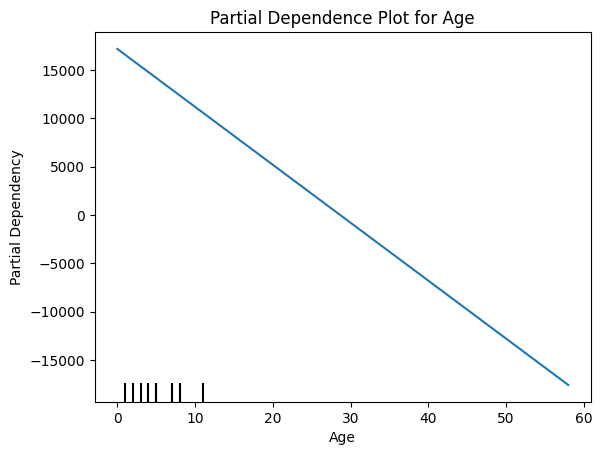

In [46]:
# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Choose the feature index for which you want to plot the partial dependence
feature_index = 5  # Adjust this index based on your feature selection

# Get the selected feature names before transformation
selected_feature_names = X_train.columns[rfe.support_]

# Get the name of the chosen feature
chosen_feature_name = selected_feature_names[feature_index]

# Create a PartialDependenceDisplay object for the chosen feature
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=underlying_model,
    X=X_val_selected,
    features=[feature_index],
    feature_names=selected_feature_names
)

# Plot the partial dependence for the chosen feature
pdp_display.plot()
plt.ylabel('Partial Dependency')
plt.xlabel(chosen_feature_name)
plt.title(f'Partial Dependence Plot for {chosen_feature_name}')
plt.show()


#### Feature Importances

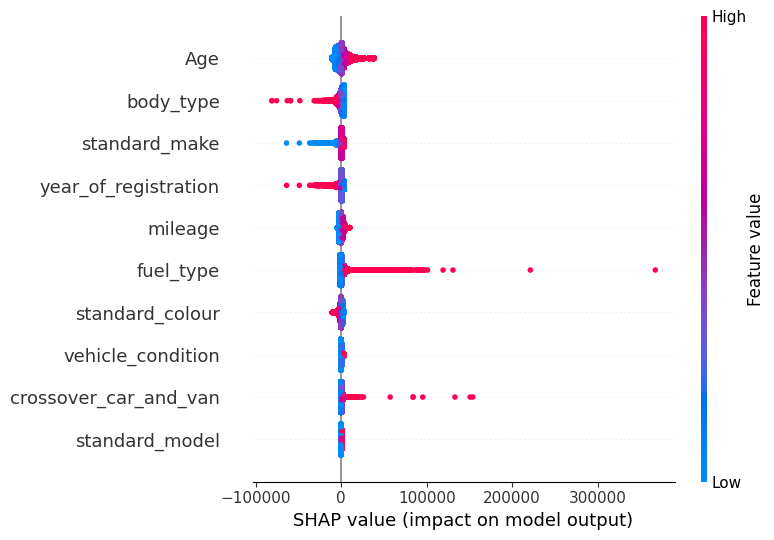

In [47]:
import shap

# Assuming X_train_selected is your training data with selected features

# Extract the underlying model from the ensemble
underlying_model = best_model.named_steps['ensemble'].estimators_[0]  # Assuming the first estimator in the ensemble is the RandomForestRegressor or GradientBoostingRegressor

# Initialize the SHAP explainer
explainer = shap.Explainer(underlying_model, X_train_selected)

# Compute SHAP values for global interpretability
shap_values_global = explainer(X_train_selected)

# Plot the global summary plot
shap.summary_plot(shap_values_global, X_train_selected, feature_names=X_train.columns)


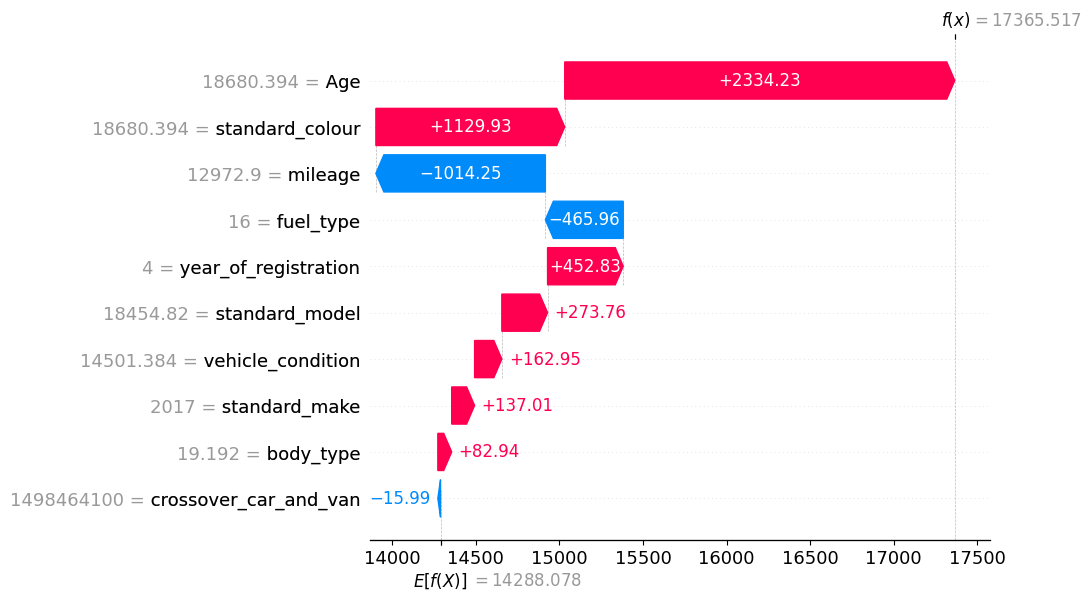

In [48]:
# Generate the SHAP plot for the 10th instance
instance_index = 10

# Get the feature names
feature_names = X_train.columns  # Assuming X_train contains all features

# Create an Explanation object for the chosen instance
shap_exp = shap.Explanation(values=shap_values[instance_index],
                             base_values=explainer.expected_value,
                             data=X_val_selected[instance_index],
                             feature_names=feature_names)

# Plot the SHAP values for the chosen instance using waterfall plot
shap.waterfall_plot(shap_exp)

plt.show()

In [57]:
import shap
from joblib import Parallel, delayed

# Assuming X_train_selected is your training data with selected features
# Extract the underlying models from the ensemble
underlying_models = best_model.named_steps['ensemble'].estimators_  # Extract all estimators in the ensemble

# Define a function to compute and plot SHAP values for a single model
def analyze_model(model, model_index, X_train_selected, feature_names):
    print(f"Analyzing Model {model_index + 1}: {type(model).__name__}")
    
    # Initialize the SHAP explainer for the model
    explainer = shap.Explainer(model, X_train_selected)
    
    # Compute SHAP values for global interpretability
    shap_values_global = explainer(X_train_selected)
    
    # Plot the global summary plot
    print(f"Summary Plot for Model {model_index + 1}")
    shap.summary_plot(shap_values_global, X_train_selected, feature_names=feature_names)

# Parallelize the SHAP analysis for all models in the ensemble
Parallel(n_jobs=-1)(delayed(analyze_model)(model, i, X_train, X_train.columns) 
                    for i, model in enumerate(underlying_models))


TypeError: unsupported operand type(s) for /: 'str' and 'int'

                Feature  Importance
2  year_of_registration  199.894758
5                   Age  199.828997
6      mileage_per_year   56.859860
8   vehicle_age_squared    9.915435
9         standard_name    0.386920
0         standard_make    0.217618
1        standard_model    0.180791
4             fuel_type    0.111423
3             body_type    0.044834
7       mileage_squared    0.007940


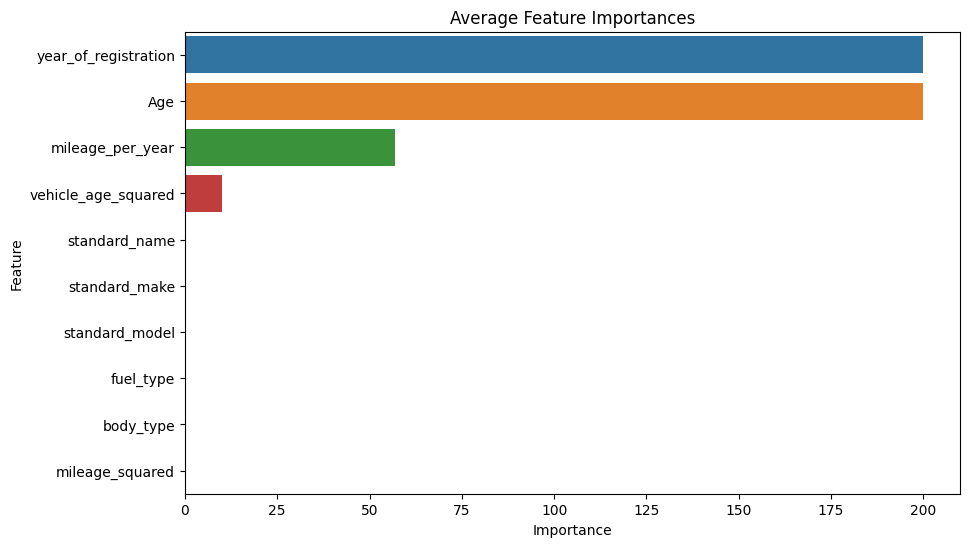

In [49]:
# Extract all models from the ensemble
ensemble_models = best_model.named_steps['ensemble'].estimators_

# Calculate the average feature importances across all models
average_feature_importances = []
for model in ensemble_models:
    if hasattr(model, 'feature_importances_'):  # For tree-based models
        average_feature_importances.append(model.feature_importances_)
    else:  # For linear regression model
        average_feature_importances.append(np.abs(model.coef_))

average_feature_importances = np.mean(average_feature_importances, axis=0)

# Get the column names of the selected features
selected_feature_names = X_train_encoded.columns[rfe.support_]

# Display feature importances in a table
importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': average_feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Average Feature Importances')
plt.show()

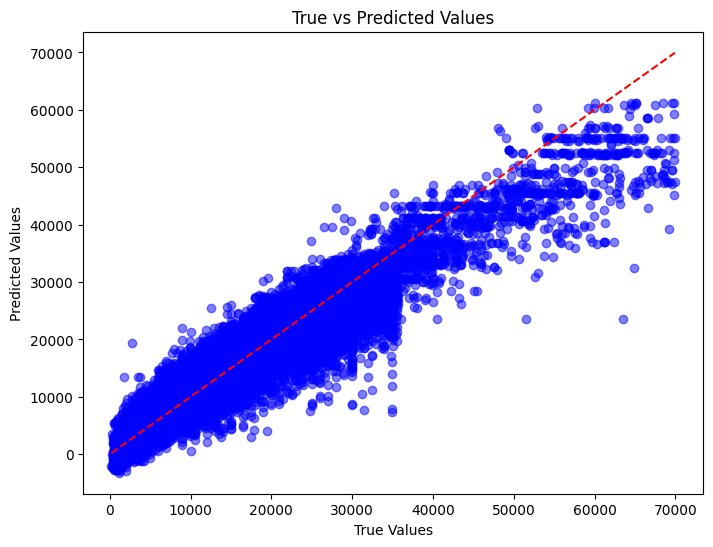

In [50]:
# Plot true vs predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()


In [51]:
# Choose a subset of data for faster computation
sample_size = min(1000, X_train_selected.shape[0])  # Adjust sample size as needed
X_train_sample = X_train_selected[:sample_size]

                Feature  Importance
2  year_of_registration  199.894758
5                   Age  199.828997
6      mileage_per_year   56.859860
8   vehicle_age_squared    9.915435
9         standard_name    0.386920
0         standard_make    0.217618
1        standard_model    0.180791
4             fuel_type    0.111423
3             body_type    0.044834
7       mileage_squared    0.007940


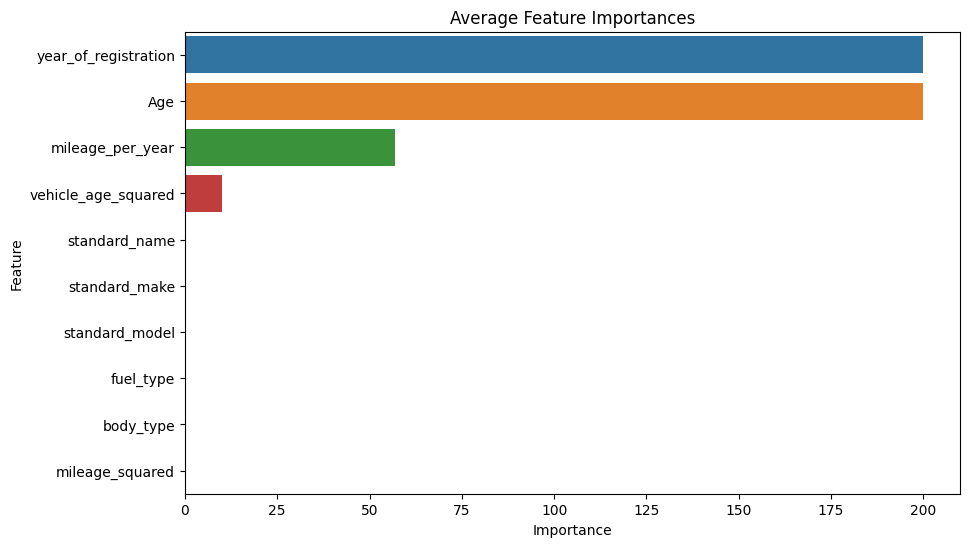

In [52]:
# Calculate the average feature importances across all models
average_feature_importances = []
for model in ensemble_models:
    if hasattr(model, 'feature_importances_'):  # For tree-based models
        average_feature_importances.append(model.feature_importances_)
    else:  # For linear regression model
        average_feature_importances.append(np.abs(model.coef_))

average_feature_importances = np.mean(average_feature_importances, axis=0)

# Get the column names of the selected features
selected_feature_names = X_train_encoded.columns[rfe.support_]

# Display feature importances in a table
importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': average_feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Average Feature Importances')
plt.show()

In [ ]:
# Choose one of the base models from the VotingRegressor ensemble
base_model_for_shap = best_model.estimators_[0]  # Selecting the first base model

# Fit the chosen base model on the subset of data
base_model_for_shap.fit(X_train_sample, y_train[:sample_size])

# Calculate SHAP values for global interpretability
explainer = shap.Explainer(base_model_for_shap, X_train_sample, algorithm='auto', feature_names=selected_feature_names)
shap_values = explainer.shap_values(X_train_sample)

# Plot global SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sample, plot_type='bar')
plt.title('Global SHAP Summary Plot')
plt.show()

In [ ]:
# Define the feature names based on RFE support
selected_feature_names = X_train_encoded.columns[rfe.support_]

# Choose one of the base models from the VotingRegressor ensemble
base_model_for_shap = voting_regressor.estimators_[0]  # Selecting the first base model

# Fit the chosen base model on the subset of data
base_model_for_shap.fit(X_train_sample, y_train[:sample_size])

# Calculate SHAP values for global interpretability
explainer = shap.Explainer(base_model_for_shap, X_train_sample, algorithm='auto', feature_names=selected_feature_names)
shap_values = explainer.shap_values(X_train_sample)

# Plot global SHAP summary plot with specific feature names
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sample, plot_type='bar', feature_names=selected_feature_names)
plt.title('Global SHAP Summary Plot')
plt.show()

In [ ]:
# Reshape shap_values_local to have a shape of (1, num_features)
shap_values_local = shap_values_local.reshape(1, -1)

# Plot local SHAP summary plot with specific feature names
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_local, X_train_sample, plot_type='bar', feature_names=selected_feature_names)
plt.title('Local SHAP Summary Plot for Instance {}'.format(instance_index))
plt.show()


In [ ]:
print("Shape of X_train_sample[0]:", X_train_sample[0].shape)


In [ ]:
# Plot local SHAP summary plot for the chosen instance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_local, [X_train_sample[instance_index]], plot_type='bar', feature_names=selected_feature_names)
plt.title('Local SHAP Summary Plot for Instance {}'.format(instance_index))
plt.show()


In [ ]:
# Reshape shap_values_local_10th to have the shape of (1, num_features)
shap_values_local_10th = shap_values_local_10th.reshape(1, -1)

# Plot local SHAP summary plot for the 10th prediction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_local_10th, [X_train_sample[tenth_prediction_index]], plot_type='bar', feature_names=selected_feature_names)
plt.title('Local SHAP Summary Plot for the 10th Prediction')
plt.show()


**Saving Model**

In [ ]:
# Save the best model as a joblib file
joblib.dump(best_model, 'linear_regresion.joblib')